In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Queremos ver el omega(R) dentro del elipsoide

In [27]:
## Calculamos las particulas dentro de un elipsoide de semieje mayor = radio
## Alineamos el eje menor mas o menos con la direccion del momento angular de forma tal que se cumpla el producto cruz entre los tres autovectores,
import numpy as np
import tenform as ten
import bines2 as bine
import scipy.interpolate as sint

def elipsoide_(x,y,z,vx,vy,vz,m,radio, nbin=20):
    
    if np.isnan(radio)== True:
        omegabar = np.nan
        omega_mean = np.nan
        med = np.nan
        return omegabar, omega_mean, med
    
    r = np.sqrt(x**2 + y**2 + z**2)

    limit, = np.where(r < radio)
    
    jx = sum(m[limit]*(y[limit]*vz[limit]-z[limit]*vy[limit]))
    jy = sum(m[limit]*(z[limit]*vx[limit]-x[limit]*vz[limit]))
    jz = sum(m[limit]*(x[limit]*vy[limit]-y[limit]*vx[limit]))

    j = np.sqrt(jx**2 + jy**2 + jz**2)
    Jt = np.ndarray(3)
    Jt[0] = jx
    Jt[1] = jy
    Jt[2] = jz
    
    tensor   = ten.tenf(x[limit], y[limit], z[limit]) #calculo el tensor de forma
    matriz   = np.linalg.eig(tensor) #saco los autovalores
    autoval  = matriz[0]
    autovec  = matriz[1]

    asort  = np.argsort(autoval) #los ordeno de menor a mayor

    A = np.sqrt(autoval[asort][2]) #semiejes
    B = np.sqrt(autoval[asort][1])
    C = np.sqrt(autoval[asort][0])
    
    V1 = autovec[:,asort][:,2] 
    V2 = autovec[:,asort][:,1]
    V3 = autovec[:,asort][:,0]
    
    
    modV = np.sqrt(np.dot(V3,V3))
    tita = np.arccos(np.dot(Jt,V3)/(j*modV))
    
    if tita > np.pi/2.:
        V3 = -V3
        
    cruz = np.cross(V3,V1)
    test = np.sign(cruz) == np.sign(V2)
    if test.all() == False:
        V2 = cruz

    aa = radio #normalizo al radio que yo quiero
    bb = (B/A)*radio
    cc = (C/A)*radio
    
    pos = np.ndarray([len(x[limit]),3])
    pos[:,0] = x[limit]
    pos[:,1] = y[limit]
    pos[:,2] = z[limit]
    
    xx = np.zeros(len(x[limit]))
    yy = np.zeros(len(x[limit]))
    zz = np.zeros(len(x[limit]))
    
    xx[:] = np.dot(pos[:],V1)
    yy[:] = np.dot(pos[:],V2)
    zz[:] = np.dot(pos[:],V3)

    Relip = np.sqrt((xx/aa)**2 + (yy/bb)**2 + (zz/cc)**2) # formula del elipsoide
    mask, = np.where(Relip <= 1.)

    xn  = xx[mask]
    yn  = yy[mask]
    zn  = zz[mask]
    
    vel = np.ndarray([len(x[limit]),3])
    vel[:,0] = vx[limit]
    vel[:,1] = vy[limit]
    vel[:,2] = vz[limit]
    
    vxx = np.zeros(len(x[limit]))
    vyy = np.zeros(len(x[limit]))
    vzz = np.zeros(len(x[limit]))
    
    vxx[:] = np.dot(vel[:],V1)
    vyy[:] = np.dot(vel[:],V2)
    vzz[:] = np.dot(vel[:],V3)
    
    vxn = vxx[mask]
    vyn = vyy[mask]
    vzn = vzz[mask]

    rn = np.sqrt(xn**2 + yn**2 + zn**2)
    Rn = np.sqrt(xn**2 + yn**2)

    Vtg = (-yn*vxn + xn*vyn)/Rn

    omega = Vtg/Rn

    med, nodos = bine.rbin1(rn,nbin)
    omega_mean = np.zeros(nbin)

#     nodos = np.linspace(0,radio,nbin+1)
#     width = np.diff(nodos)
#     med = nodos[:-1] + width/2.
    
    for i in range(0,nbin):
        inbin, = np.where((rn > nodos[i]) & (rn < nodos[i+1]))

        omega_mean[i] = np.mean(omega[inbin])

    finterp = sint.interp1d(med,omega_mean,fill_value="extrapolate")

    omegabar = finterp(radio)
    
#     label .end
    return omegabar, omega_mean, med #xn, yn, zn, V1, V2, V3, A, B, C

In [7]:
import numpy as np
data00 = np.loadtxt('../_data/correcciones/lbar_time_GD2.dat')
time_M31gd  = data00[:,0]
lbar1_M31gd = data00[:,1]
lbar2_M31gd = data00[:,2]
lbar3_M31gd = data00[:,3]
lbar4_M31gd = data00[:,4]
lbar5_M31gd = data00[:,5]
lbar6_M31gd = data00[:,6]

data01 = np.loadtxt('../_data/correcciones/lbar_time_GS2_001.dat')
time_M31gs  = data01[:,0]
lbar1_M31gs = data01[:,1]
lbar2_M31gs = data01[:,2]
lbar3_M31gs = data01[:,3]
lbar4_M31gs = data01[:,4]
lbar5_M31gs = data01[:,5]
lbar6_M31gs = data01[:,6]

data02 = np.loadtxt('../_data/correcciones/lbar_time_GS2_002.dat')
time_MWgs  = data02[:,0]
lbar1_MWgs = data02[:,1]
lbar2_MWgs = data02[:,2]
lbar3_MWgs = data02[:,3]
lbar4_MWgs = data02[:,4]
lbar5_MWgs = data02[:,5]
lbar6_MWgs = data02[:,6]

### M31 gadget

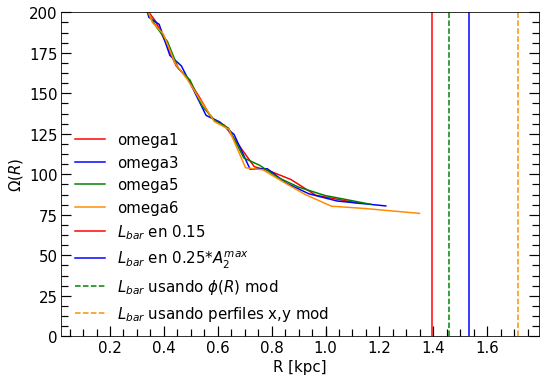

In [33]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
import tenform as ten
import elipsoide2 as elip


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
atime = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = atime[:,2]

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'


path = '/mnt/is2/alejandro/ornella/'
# snapshot=range(496,300,-1)
k = 0
# for isnap in snapshot:
isnap = 496
snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
#     halos = (0,1,3)
# for i in halos:
j = 0
cm   = snap['subhalo_'+ str('%03d' %j) + '/Center'][()]
r200 = snap['subhalo_'+ str('%03d' %j) + '/R200'][()]

pstr = snap['subhalo_'+ str('%03d' %j) + '/Str/Coordinates'][()]
IDs  = snap['subhalo_'+ str('%03d' %j) + '/Str/Ids'][()]
mstr = snap['subhalo_'+ str('%03d' %j) + '/Str/Masses'][()]
vel  = snap['subhalo_'+ str('%03d' %j) + '/Str/Velocities'][()]

pgas = snap['subhalo_'+ str('%03d' %j) + '/Gas/Coordinates'][()]
mgas = snap['subhalo_'+ str('%03d' %j) + '/Gas/Masses'][()]

pdrk = snap['subhalo_'+ str('%03d' %j) + '/Drk/Coordinates'][()]
mdrk = snap['subhalo_'+ str('%03d' %j) + '/Drk/Masses'][()]

z = a0/aexp[isnap] - 1.
Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
time = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
mstr = mstr*1e10/h
mgas = mgas*1e10/h
mdrk = mdrk*1e10/h

r200 = r200*aexp[isnap]/h
rgal = 0.15*r200

limit = np.where(rstr<rgal)
r_sort = np.sort(rstr[limit])
r_indice = np.argsort(rstr[limit])

Mc_str = np.cumsum((mstr[limit])[r_indice])
M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
razon = Mc_str/M_gal
cincuenta, = np.where(razon < 0.5)

r50 = r_sort[cincuenta][-1]              

#------------------masa total en r200 (Mvir)--------------------------         
veloc,=np.where(rstr<r50)

#----------componentes de la velocidad del centro de masa------------
vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

#------------------------------------------------------------------
rtot = np.concatenate([rstr, rgas, rdrk])
mtot = np.concatenate([mstr, mgas, mdrk])

limit_tot   = np.where(rtot<r200)
rtot_sort   = np.sort(rtot[limit_tot])
rtot_indice = np.argsort(rtot[limit_tot])

Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)


lbar1 = lbar1_M31gd[k]
lbar2 = lbar2_M31gd[k]
lbar3 = lbar3_M31gd[k]
lbar4 = lbar4_M31gd[k]
lbar5 = lbar5_M31gd[k]
lbar6 = lbar6_M31gd[k]

k = k+1

#-----------------------------------------------------------------------
#-----OMEGA BAR---------------------------------------------------------
#-----------------------------------------------------------------------
Rn = np.sqrt(xn**2 + yn**2)

Vtg = (-yn*vxn + xn*vyn)/Rn

omega = Vtg/Rn

#-----Omega_bar 3---------------------------------------------------------

omegabar13, omega_mean13, med13 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar1,nbin=20)
omegabar23, omega_mean23, med23 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar2,nbin=20)
omegabar33, omega_mean33, med33 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar3,nbin=20)
omegabar43, omega_mean43, med43 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar4,nbin=20)
omegabar53, omega_mean53, med53 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar5,nbin=20)
omegabar63, omega_mean63, med63 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar6,nbin=20)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))#, sharex=True)
    #                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(med13, omega_mean13, label='omega1',color='r')
# ax.plot(med23, omega_mean23, label='omega2')
ax.plot(med33, omega_mean33, label='omega3',color='b')
# ax.plot(med43, omega_mean43, label='omega4')
ax.plot(med53, omega_mean53, label='omega5', color='g')
ax.plot(med63, omega_mean63, label='omega6', color='darkorange')
ax.axvline(x=lbar1,color='r', label='$L_{bar}$ en 0.15')
ax.axvline(x=lbar3,color='b',label='$L_{bar}$ en 0.25*$A_2^{max}$')
# ax.axvline(x=lbar2,color='g',label='$L_{bar}$ usando $\phi(R)$')
ax.axvline(x=lbar5,color='g',label='$L_{bar}$ usando $\phi(R)$ mod', ls='--')
# ax.axvline(x=lbar4,color='darkorange',label='$L_{bar}$ usando perfiles x,y')
ax.axvline(x=lbar6,color='darkorange',label='$L_{bar}$ usando perfiles x,y mod', ls='--')
# ax.axhline(y=omegabar13, color='r', ls='--')
# ax.axhline(y=omegabar53,color='g', ls='--')
# ax.axhline(y=omegabar33,color='b', ls='--')
# ax.axhline(y=omegabar63,color='darkorange', ls='--')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$\Omega(R)$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylim(0,200)
ax.legend(fontsize=15,frameon=False,loc=3)



### M31 gasoline 

/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: divide by zero encountered in divide


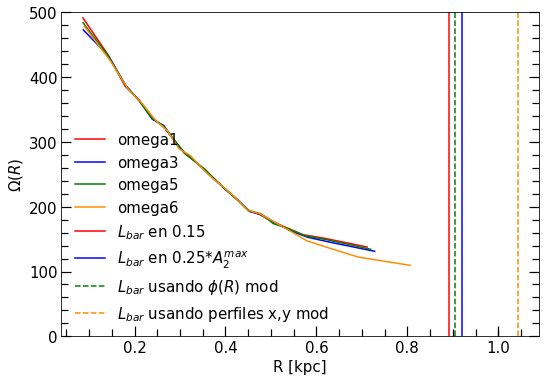

In [38]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
from matplotlib.ticker import MultipleLocator
import elipsoide2 as elip

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
snapshot = snapshot[::-1]

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'

k=0
# for j in range(len(snapshot)-1,32,-1):
j=0
snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

#     halos =(1,2)#4)
i = 1

#     for i in halos:
cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

pgas = snap['subhalo_00'+str('%s'%i)+'/Gas/Coordinates'][()]
mgas = snap['subhalo_00'+str('%s'%i)+'/Gas/Masses'][()]

pdrk = snap['subhalo_00'+str('%s'%i)+'/Drk/Coordinates'][()]
mdrk = snap['subhalo_00'+str('%s'%i)+'/Drk/Masses'][()]

#paso las coordenadas al centro de la galaxia
xstr = (pstr[:,0]-cm[0])
ystr = (pstr[:,1]-cm[1])
zstr = (pstr[:,2]-cm[2])
rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

xgas = (pgas[:,0]-cm[0])
ygas = (pgas[:,1]-cm[1])
zgas = (pgas[:,2]-cm[2])
rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

xdrk = (pdrk[:,0]-cm[0])
ydrk = (pdrk[:,1]-cm[1])
zdrk = (pdrk[:,2]-cm[2])
rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
#----------------------------------------------------------------------
r200 = r200*aexp
rgal = 0.15*r200          #defino el radio de la galaxia

limit = np.where(rstr<rgal)         #hago un límite de los r dentro de rgal
r_sort = np.sort(rstr[limit])       #acomodo los r de menor a mayor
r_indice = np.argsort(rstr[limit])  #saco los argumentos de r acomodados de menor a mayor

Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
razon = Mc_str/Mgal 
noventa, = np.where(razon < 0.9)
cincuenta, = np.where(razon < 0.5)

r90 = r_sort[noventa][-1]   #radio a 90% la masa
r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
veloc, = np.where(rstr < r50)

vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
vx = vel[:,0] - vxcm
vy = vel[:,1] - vycm
vz = vel[:,2] - vzcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

#------------------------------------------------------------------
rtot = np.concatenate([rstr, rgas, rdrk])
mtot = np.concatenate([mstr, mgas, mdrk])

limit_tot   = np.where(rtot<r200)
rtot_sort   = np.sort(rtot[limit_tot])
rtot_indice = np.argsort(rtot[limit_tot])

Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

Vtot = np.sqrt(G*Mc_tot/rtot_sort)

lbar1 = lbar1_M31gs[k]
lbar2 = lbar2_M31gs[k]
lbar3 = lbar3_M31gs[k]
lbar4 = lbar4_M31gs[k]
lbar5 = lbar5_M31gs[k]
lbar6 = lbar6_M31gs[k]

k = k+1
#-----------------------------------------------------------------------
#-----OMEGA BAR---------------------------------------------------------
#-----------------------------------------------------------------------
Rn = np.sqrt(xn**2 + yn**2)

Vtg = (-yn*vxn + xn*vyn)/Rn

omega = Vtg/Rn

#-----Omega_bar 3---------------------------------------------------------


omegabar13, omega_mean13, med13 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar1,nbin=20)
omegabar23, omega_mean23, med23 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar2,nbin=20)
omegabar33, omega_mean33, med33 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar3,nbin=20)
omegabar43, omega_mean43, med43 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar4,nbin=20)
omegabar53, omega_mean53, med53 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar5,nbin=20)
omegabar63, omega_mean63, med63 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar6,nbin=20)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))#, sharex=True)
    #                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(med13, omega_mean13, label='omega1',color='r')
# ax.plot(med23, omega_mean23, label='omega2')
ax.plot(med33, omega_mean33, label='omega3',color='b')
# ax.plot(med43, omega_mean43, label='omega4')
ax.plot(med53, omega_mean53, label='omega5', color='g')
ax.plot(med63, omega_mean63, label='omega6', color='darkorange')
ax.axvline(x=lbar1,color='r', label='$L_{bar}$ en 0.15')
ax.axvline(x=lbar3,color='b',label='$L_{bar}$ en 0.25*$A_2^{max}$')
# ax.axvline(x=lbar2,color='g',label='$L_{bar}$ usando $\phi(R)$')
ax.axvline(x=lbar5,color='g',label='$L_{bar}$ usando $\phi(R)$ mod', ls='--')
# ax.axvline(x=lbar4,color='darkorange',label='$L_{bar}$ usando perfiles x,y')
ax.axvline(x=lbar6,color='darkorange',label='$L_{bar}$ usando perfiles x,y mod', ls='--')
# ax.axhline(y=omegabar13, color='r', ls='--')
# ax.axhline(y=omegabar53,color='g', ls='--')
# ax.axhline(y=omegabar33,color='b', ls='--')
# ax.axhline(y=omegabar63,color='darkorange', ls='--')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$\Omega(R)$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylim(0,500)
ax.legend(fontsize=15,frameon=False,loc=3)

### MW gasoline 

/home/omarioni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: divide by zero encountered in divide


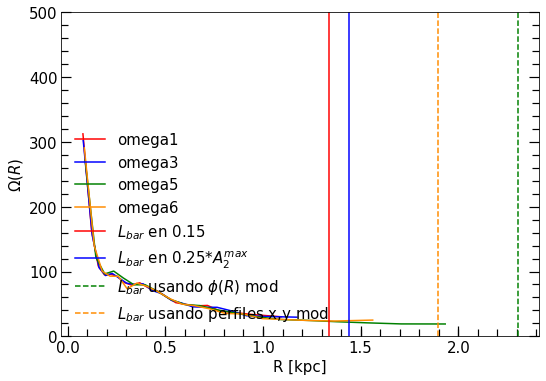

In [41]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
from matplotlib.ticker import MultipleLocator
import elipsoide2 as elip

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
snapshot = snapshot[::-1]

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'

k=0
# for j in range(len(snapshot)-1,32,-1):
j=0
snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

#     halos =(1,2)#4)
i = 2

#     for i in halos:
cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

pgas = snap['subhalo_00'+str('%s'%i)+'/Gas/Coordinates'][()]
mgas = snap['subhalo_00'+str('%s'%i)+'/Gas/Masses'][()]

pdrk = snap['subhalo_00'+str('%s'%i)+'/Drk/Coordinates'][()]
mdrk = snap['subhalo_00'+str('%s'%i)+'/Drk/Masses'][()]

#paso las coordenadas al centro de la galaxia
xstr = (pstr[:,0]-cm[0])
ystr = (pstr[:,1]-cm[1])
zstr = (pstr[:,2]-cm[2])
rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

xgas = (pgas[:,0]-cm[0])
ygas = (pgas[:,1]-cm[1])
zgas = (pgas[:,2]-cm[2])
rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

xdrk = (pdrk[:,0]-cm[0])
ydrk = (pdrk[:,1]-cm[1])
zdrk = (pdrk[:,2]-cm[2])
rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
#----------------------------------------------------------------------
r200 = r200*aexp
rgal = 0.15*r200          #defino el radio de la galaxia

limit = np.where(rstr<rgal)         #hago un límite de los r dentro de rgal
r_sort = np.sort(rstr[limit])       #acomodo los r de menor a mayor
r_indice = np.argsort(rstr[limit])  #saco los argumentos de r acomodados de menor a mayor

Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
razon = Mc_str/Mgal 
noventa, = np.where(razon < 0.9)
cincuenta, = np.where(razon < 0.5)

r90 = r_sort[noventa][-1]   #radio a 90% la masa
r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
veloc, = np.where(rstr < r50)

vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
vx = vel[:,0] - vxcm
vy = vel[:,1] - vycm
vz = vel[:,2] - vzcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

#------------------------------------------------------------------
rtot = np.concatenate([rstr, rgas, rdrk])
mtot = np.concatenate([mstr, mgas, mdrk])

limit_tot   = np.where(rtot<r200)
rtot_sort   = np.sort(rtot[limit_tot])
rtot_indice = np.argsort(rtot[limit_tot])

Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

Vtot = np.sqrt(G*Mc_tot/rtot_sort)

lbar1 = lbar1_MWgs[k]
lbar2 = lbar2_MWgs[k]
lbar3 = lbar3_MWgs[k]
lbar4 = lbar4_MWgs[k]
lbar5 = lbar5_MWgs[k]
lbar6 = lbar6_MWgs[k]

k = k+1
#-----------------------------------------------------------------------
#-----OMEGA BAR---------------------------------------------------------
#-----------------------------------------------------------------------
Rn = np.sqrt(xn**2 + yn**2)

Vtg = (-yn*vxn + xn*vyn)/Rn

omega = Vtg/Rn

#-----Omega_bar 3---------------------------------------------------------


omegabar13, omega_mean13, med13 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar1,nbin=20)
omegabar23, omega_mean23, med23 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar2,nbin=20)
omegabar33, omega_mean33, med33 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar3,nbin=20)
omegabar43, omega_mean43, med43 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar4,nbin=20)
omegabar53, omega_mean53, med53 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar5,nbin=20)
omegabar63, omega_mean63, med63 = elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar6,nbin=20)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))#, sharex=True)
    #                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(med13, omega_mean13, label='omega1',color='r')
# ax.plot(med23, omega_mean23, label='omega2')
ax.plot(med33, omega_mean33, label='omega3',color='b')
# ax.plot(med43, omega_mean43, label='omega4')
ax.plot(med53, omega_mean53, label='omega5', color='g')
ax.plot(med63, omega_mean63, label='omega6', color='darkorange')
ax.axvline(x=lbar1,color='r', label='$L_{bar}$ en 0.15')
ax.axvline(x=lbar3,color='b',label='$L_{bar}$ en 0.25*$A_2^{max}$')
# ax.axvline(x=lbar2,color='g',label='$L_{bar}$ usando $\phi(R)$')
ax.axvline(x=lbar5,color='g',label='$L_{bar}$ usando $\phi(R)$ mod', ls='--')
# ax.axvline(x=lbar4,color='darkorange',label='$L_{bar}$ usando perfiles x,y')
ax.axvline(x=lbar6,color='darkorange',label='$L_{bar}$ usando perfiles x,y mod', ls='--')
# ax.axhline(y=omegabar13, color='r', ls='--')
# ax.axhline(y=omegabar53,color='g', ls='--')
# ax.axhline(y=omegabar33,color='b', ls='--')
# ax.axhline(y=omegabar63,color='darkorange', ls='--')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$\Omega(R)$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylim(0,500)
ax.legend(fontsize=15,frameon=False,loc=3)

### Calculo de phi(R) GADGET 

phimax =  0.8721061944961548
[0.08535493 0.15999663 0.22198452 0.28126317 0.34353369 0.40907907
 0.47972488 0.55746293 0.64450407 0.74486476 0.8638854  1.01622343
 1.22006631 1.49450612 1.83889914 2.24404097 2.71798515 3.34984827
 4.18532515 5.21512604]
[ 0.8771314   0.85675192  0.85562509  0.85541171  0.85959744  0.88791621
  0.87375146  0.86747968  0.86082882  0.85650271  0.86027068  0.8511256
  0.85977226  0.92525667  1.13256836 -1.30073345  0.4916119   1.43425679
  0.22203912  0.47739497]


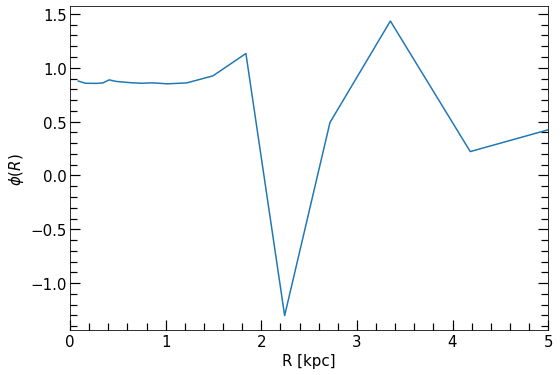

In [10]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
aa = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = aa[:,2]

# snapshot=range(496,300,-1) #SNAPSHOTS

path = '/mnt/is2/alejandro/ornella/'

# for isnap in snapshot:

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
      

isnap=496

snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

# halos = (0,1,3)

# for i in halos:
i=0
cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]

pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

z     = a0/aexp[isnap] - 1.
Ht    = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
time  = tiempo.conv(z, h, omega_lambda, omega_matter)

#paso las coordenadas al centro de la galaxia y paso a coordenadas físicas
xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
r    = np.sqrt(xstr**2+ystr**2+zstr**2)

#paso las velocidades a unidades físicas
v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

mstr = mstr*1e10/h     #masa a unidades físicas

r200 = r200*aexp[isnap]/h #radio virial a unidades fisicas

rgal = 0.15*r200          #defino el radio de la galaxia

limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
razon = Mc_str/Mgal 
noventa, = np.where(razon < 0.9)
cincuenta, = np.where(razon < 0.5)

r90 = r_sort[noventa][-1]   #radio a 90% la masa
r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#componentes de la velocidad del centro de masa
veloc, = np.where(r < r50)

vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

#-------------------------------------------------------------------------------------
#hago la rotación de las coordenadas respecto del momento angular    
e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

corte1, = np.where(r<3.*aexp[isnap])
corte2, = np.where(r<6.*aexp[isnap])

nbin = 20
A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], nbin)
A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], nbin)
#     A2_2, phi, rbin2 = strng.a2(mstr[corte1], xn[corte1], yn[corte1], 20)

print 'phimax = ', phimax
print rbin
print phi

# dat = np.ndarray([nbin,3])
# dat[:,0] = rbin
# dat[:,1] = A2
# dat[:,2] = phi
# np.savetxt(path2 + 'phi_R_GD_'+str('%03d'%i)+'.dat',dat, fmt='%12.8f')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)



ax.plot(rbin,phi)

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$\phi(R)$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
# ax.set_ylim(-0.5,0.5)
ax.set_xlim(0,5)
ax.legend(frameon=False)
plt.show()



### Calculo de phi(R) GASOLINE

In [6]:
import h5py
import rotation_mio as rot
import barstrength2 as strng
import scipy.interpolate as sint
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

# path = '/home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
snapshot = snapshot[::-1]


path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
# archivo = open(path2 + 'lbar_set_GS.dat','a')


# for j in range(len(snapshot)-1,32,-1):
j=0
#     path = '/home/ornela/SimCLUES/'



halos = (1,2,4)

for i in halos:  

    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
    time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
    h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
    aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    #paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    #----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #-----------------------------------------------------------------------

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    #-----------------------------------------------------------------------------------

    #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte1, = np.where(r<3*aexp)
    corte2, = np.where(r<6.*aexp)

    A2, phi, rbin = strng.a2(mstr[corte2], xn[corte2], yn[corte2], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)

    # print rbin
    # print phi
    print 'phimax = ', phimax

# #     data = np.ndarray([nbin,3])
# #     data[:,0] = rbin
# #     data[:,1] = A2
# #     data[:,2] = phi
# #     np.savetxt(path2 + 'phi_R_GS_'+str('%03d'%i)+'.dat',data, fmt='%12.8f')

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))#, sharex=True)
# #                        gridspec_kw = {'height_ratios':[2,5]})
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

# ax.plot(rbin,phi, label='M31gs')
# ax.minorticks_on()
# ax.tick_params( labelsize=15)
# ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
# ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
# ax.set_ylabel('$\phi(R)$',fontsize=15)
# ax.set_xlabel('R [kpc]',fontsize=15)
# # ax.set_ylim(-0.5,0.5)
# ax.set_xlim(0,5)
# ax.legend(frameon=False)
# plt.show()

phimax =  -0.001345067285001278
phimax =  -0.9345619678497314
phimax =  0.1357543170452118


In [8]:
import numpy as np
data1 = np.loadtxt('../_data/correcciones/phi_R_GD_000.dat')
rbin_M31gd = data1[:,0]
A2_M31gd   = data1[:,1]
phi_M31gd  = data1[:,2]

data2 = np.loadtxt('../_data/correcciones/phi_R_GD_001.dat')
rbin_MWgd = data2[:,0]
A2_MWgd   = data2[:,1]
phi_MWgd  = data2[:,2]

data3 = np.loadtxt('../_data/correcciones/phi_R_GD_003.dat')
rbin_M33gd = data3[:,0]
A2_M33gd   = data3[:,1]
phi_M33gd  = data3[:,2]

data4 = np.loadtxt('../_data/correcciones/phi_R_GS_001.dat')
rbin_M31gs = data4[:,0]
A2_M31gs   = data4[:,1]
phi_M31gs  = data4[:,2]

data5 = np.loadtxt('../_data/correcciones/phi_R_GS_002.dat')
rbin_MWgs = data5[:,0]
A2_MWgs   = data5[:,1]
phi_MWgs  = data5[:,2]

data6 = np.loadtxt('../_data/correcciones/phi_R_GS_004.dat')
rbin_M33gs = data6[:,0]
A2_M33gs   = data6[:,1]
phi_M33gs  = data6[:,2]

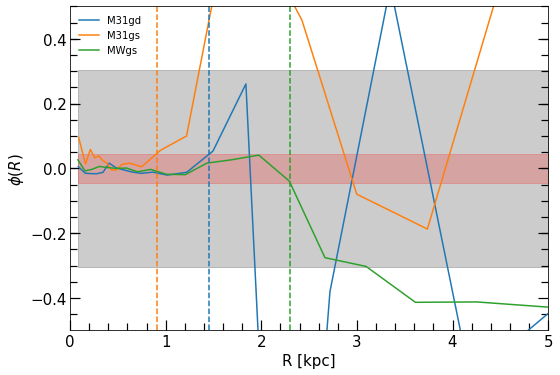

In [9]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))#, sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

angulo = 0.3
angulo2 = 0.044

line1 = np.arcsin(angulo)
line2 = -np.arcsin(angulo)

line1_ = np.arcsin(angulo2)
line2_ = -np.arcsin(angulo2)

phimax_M31gd =  0.8721061944961548
phimax_M31gs =-0.001345067285001278
phimax_MWgs  =  -0.9345619678497314

ax.plot(rbin_M31gd,phi_M31gd-phimax_M31gd, label='M31gd')
ax.plot(rbin_M31gs,phi_M31gs-phimax_M31gs, label='M31gs')
ax.plot(rbin_MWgs,phi_MWgs-phimax_MWgs, label='MWgs')
# ax.axvline(x=lbar1,color='r')
# ax.axvline(x=lbar3,color='b')
ax.fill_between(rbin_M31gd,line2,line1,color='k',alpha=0.2)
ax.fill_between(rbin_M31gd,line2_,line1_,color='red',alpha=0.2)
# ax.axvline(x=lbar2,color='g')
ax.axvline(x=lbar5_M31gd[0],ls='--',color='tab:blue')
ax.axvline(x=lbar5_M31gs[0],ls='--',color='tab:orange')
ax.axvline(x=lbar5_MWgs[0],ls='--',color='tab:green')
# ax.axvline(x=lbar4,color='darkorange')
# ax.axvline(x=lbar6,color='darkorange',ls='--')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$\phi(R)$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
ax.set_ylim(-0.5,0.5)
ax.set_xlim(0,5)
ax.legend(frameon=False)
plt.show()

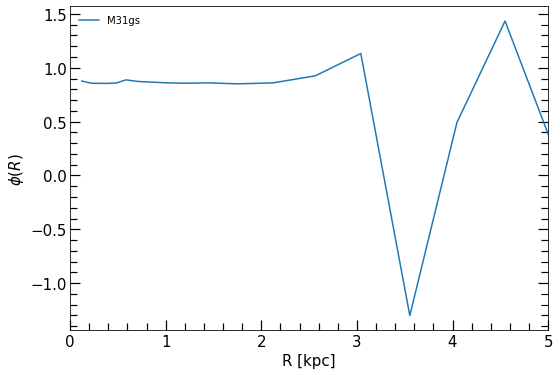

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))#, sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)


# ax.plot(rbin_M31gd,phi_M31gd-phimax_M31gd, label='M31gd')
ax.plot(rbin_M31gd,phi_M31gd, label='M31gs')
# ax.plot(rbin_MWgs,phi_MWgs-phimax_MWgs, label='MWgs')
# ax.axvline(x=lbar1,color='r')
# ax.axvline(x=lbar3,color='b')
# ax.fill_between(rbin_M31gd,line2,line1,color='k',alpha=0.2)
# ax.fill_between(rbin_M31gd,line2_,line1_,color='red',alpha=0.2)
# ax.axvline(x=lbar2,color='g')
# ax.axvline(x=lbar5_M31gd[0],ls='--',color='tab:blue')
# ax.axvline(x=lbar5_M31gs[0],ls='--',color='tab:orange')
# ax.axvline(x=lbar5_MWgs[0],ls='--',color='tab:green')
# ax.axvline(x=lbar4,color='darkorange')
# ax.axvline(x=lbar6,color='darkorange',ls='--')
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$\phi(R)$',fontsize=15)
ax.set_xlabel('R [kpc]',fontsize=15)
# ax.set_ylim(-0.5,0.5)
ax.set_xlim(0,5)
ax.legend(frameon=False)
plt.show()

In [57]:
print phi_M31gd.max()

1.43425703
